### Introduction
In today's digital landscape, leading e-commerce platforms such as Amazon employs sophisticated recommendation systems to cater to the diverse preferences of their users. These systems analyze user behavior, purchase history, and preferences to generate accurate and relevant recommendations, thereby enhancing the user experience and driving sales.

To build the recommendation model, I will employ collaborative filtering to give customers recommedations according to the patterns and similarities between users and items. In this project, I will utilize Amazon beauty products dataset which consists of for key attributes: 

* userId : Every user identified with a unique id
* productId : Every product identified with a unique id
* Rating : Rating of the corresponding product by the corresponding user
* timestamp : Time of the rating 

### Import Library

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from scipy.sparse.linalg import svds
from scipy import sparse

### Load Dataset

In [37]:
# Open the text file for reading
file_path = '/Users/Yu/Documents/GitHub/Final_Project/Amazon_Beauty_Products.txt'
with open(file_path, 'r') as file:
    lines = file.readlines()

In [38]:
# Initialize lists to store data
user_ids = []
product_ids = []
ratings = []
timestamps = []

# Parse and extract data from each line
for line in lines:
    data = line.strip().split(',')
    if len(data) == 4:
        product_ids.append(data[0])
        user_ids.append(data[1])
        ratings.append(float(data[2]))
        timestamps.append(int(data[3]))

# Create a DataFrame with the extracted data
df = pd.DataFrame({
    'userId': user_ids,
    'productId': product_ids,
    'rating': ratings,
    'timestamp': timestamps
})

df.head()

,userId,productId,rating,timestamp
0,A1V6B6TNIC10QE,0143026860,1.0,1424304000
1,A2F5GHSXFQ0W6J,0143026860,4.0,1418860800
2,A1572GUYS7DGSR,0143026860,4.0,1407628800
3,A1PSGLFK1NSVO,0143026860,5.0,1362960000
4,A6IKXKZMTKGSC,0143026860,5.0,1324771200


In [39]:
df.shape

(371345, 4)

In [40]:
df['userId'].nunique()

324038

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371345 entries, 0 to 371344
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     371345 non-null  object 
 1   productId  371345 non-null  object 
 2   rating     371345 non-null  float64
 3   timestamp  371345 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ MB


In [42]:
df.describe()

,rating,timestamp
count,371345.000000,3.713450e+05
mean,4.112093,1.440742e+09
std,1.362099,6.962743e+07
min,1.000000,9.474624e+08
25%,4.000000,1.416096e+09
50%,5.000000,1.456963e+09
75%,5.000000,1.485562e+09
max,5.000000,1.538438e+09


In [43]:
df.isnull().sum()

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

Recommendation systems have a user cold_start problem. In order to avoid the lack of inforamtion to model user's preferences, I only keep the users with at least 4 interactoins here.

In [12]:
user_interactions_count_df = df.groupby(['userId', 'productId']).size().groupby('userId').size()
print('# users: %d' % len(user_interactions_count_df))
users_with_enough_interactions_df = user_interactions_count_df[user_interactions_count_df >= 4].reset_index()[['userId']]
print('# users with at least 4 interactions: %d' % len(users_with_enough_interactions_df))

# users: 324038
# users with at least 4 interactions: 1864


In [13]:
print('# of interactions: %d' % len(df))
interactions_from_selected_users_df = df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'userId',
               right_on = 'userId')
print('# of interactions from users with at least 4 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions: 371345
# of interactions from users with at least 4 interactions: 9862


In [14]:
interactions_from_selected_users_df.shape

(9862, 4)

In [15]:
duplicate_rows = interactions_from_selected_users_df[interactions_from_selected_users_df.duplicated()]
num_duplicates = len(duplicate_rows)
num_duplicates

1075

In [16]:
# Aggregate the duplicate entries
df_clean = interactions_from_selected_users_df.groupby(['userId', 'productId']).mean().reset_index() 

In [17]:
df_clean.shape

(8720, 4)

### Exploratory Data Analysis

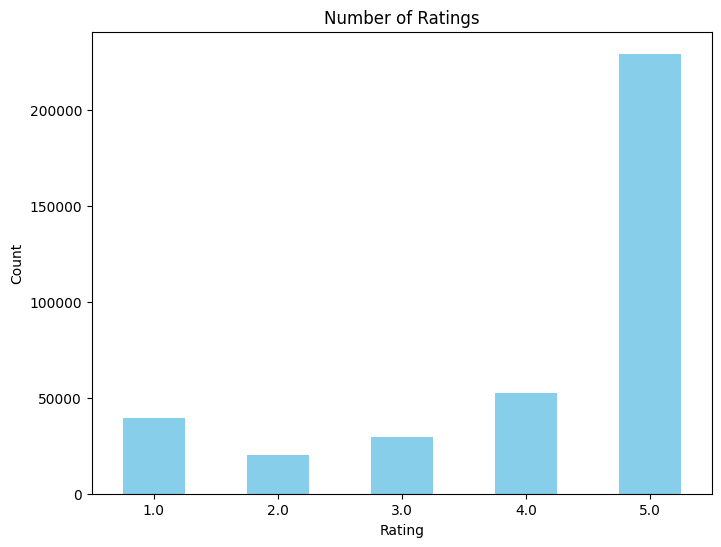

In [52]:
# First we analyze the number of ratings

plt.figure(figsize=(8, 6))
df['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Number of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

We can see that most of users rated 5 for the products they purchased. Now, we make it deeper to explore the distribution of ratings and mean ratings recorded for each product.

In [45]:
rating_counts = pd.DataFrame(df['rating'].value_counts()).reset_index()
rating_counts.columns = ['Labels', 'Ratings']
# For the ratings like 4.5 means a user rated the same product twice with different ratings, I will drop these ratings for a better view of the data.

rating_counts

,Labels,Ratings
0,5.0,229549
1,4.0,52687
2,1.0,39261
3,3.0,29555
4,2.0,20293


/opt/anaconda3/envs/the_one/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/the_one/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/anaconda3/envs/the_one/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


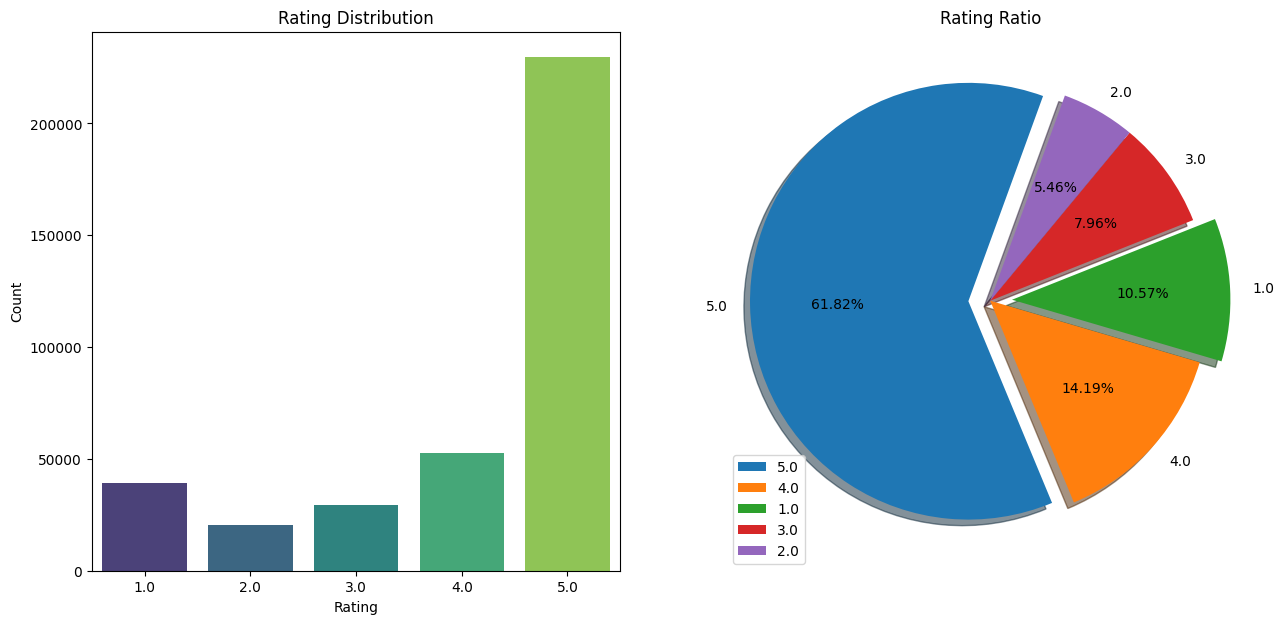

In [47]:
# Rating distribution and rating ratio

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
sns.countplot(data=df, x='rating', palette='viridis', ax=ax1)
ax1.set_xlabel('Rating')
ax1.set_ylabel('Count')
ax1.set_title('Rating Distribution')


explode = (0.1, 0, 0.1, 0, 0)
ax2.pie(rating_counts["Ratings"], explode=explode, labels=rating_counts.Labels, autopct='%1.2f%%',
        shadow=True, startangle=70)
ax2.axis('equal')
plt.title("Rating Ratio")
plt.legend(rating_counts.Labels, loc=3)
plt.show()

In [50]:
df_rating_by_mean=pd.DataFrame({'Number of Rating':df.groupby('productId').count()['rating'], 
                        'Mean Rating':df.groupby('productId')['rating'].mean()})
df_rating_by_mean.head()

,Number of Rating,Mean Rating
productId,,
0061073717,2,5.000000
0143026860,17,4.117647
014789302X,20,4.350000
0571348351,3,5.000000
0692508988,1,5.000000


In [53]:
# Create a histogram using Plotly Express
fig = px.histogram(df_rating_by_mean, x='Mean Rating', nbins=30, title='Distribution of Mean Rating', color_discrete_sequence=['slateblue'])

fig.update_layout(
    xaxis_title='Mean Rating',
    yaxis_title='Count',
    showlegend=False  
)

fig.show()


We can see from the plot that most of the products have a mean rating of 5. 

In [55]:
df_rating_sorted = df_rating_by_mean.sort_values(by=['Mean Rating', 'Number of Rating'], ascending=False)
df_rating_sorted

,Number of Rating,Mean Rating
productId,,
B000KNELAW,121,5.0
B000GCPXN6,37,5.0
B00079PB6M,22,5.0
B00MHYLOMA,22,5.0
B004LTF18M,17,5.0
...,...,...
B01HHFEA42,1,1.0
B01HI6M8H6,1,1.0
B01HIE3EK8,1,1.0


Then we can create a stacked bar chart for the frequencies of ratings for each product. Here I choose the top 10 (based on frequency) to plot. 


In [56]:
# Pivot the DataFrame to get frequencies of ratings for each product
products_ratings = df.pivot_table(index='productId', columns='rating', values='timestamp', aggfunc='count', fill_value=0)
products_ratings.columns = ['Rating ' + str(col) for col in products_ratings.columns]
products_ratings['Total Ratings'] = products_ratings.sum(axis=1)

# Sort the products by the total number of ratings in descending order
df_sorted = products_ratings.sort_values('Total Ratings', ascending=False)

# Select the top 10 products by total number of ratings
top_10_products = df_sorted.head(10)

# Create data for the stacked bar chart
data = []

for rating_col in ['Rating 1.0', 'Rating 2.0', 'Rating 3.0', 'Rating 4.0', 'Rating 5.0']:
    data.append(go.Bar(
        x=top_10_products.index,
        y=top_10_products[rating_col],
        name=rating_col,
    ))

# Create the stacked bar chart
layout = go.Layout(
    barmode='stack',  
    xaxis=dict(title='Product ID'),
    yaxis=dict(title='Frequency'),
    title='Frequencies of Ratings for Each Product (Top 10)',
)

fig = go.Figure(data=data, layout=layout)

fig.show()




In [57]:
top_10_products.head()

,Rating 1.0,Rating 2.0,Rating 3.0,Rating 4.0,Rating 5.0,Total Ratings
productId,,,,,,
B000FOI48G,414,292,552,1624,5790,8672
B000GLRREU,377,271,535,1571,5587,8341
1620213982,44,36,81,520,4111,4792
B001QY8QXM,152,121,220,606,3445,4544
B01DKQAXC0,412,238,264,468,2864,4246


I also create a table for each rating to see the number of ratings per userId. I only chose the top 10 userIds for view.

In [58]:
# Pivot the table to get ratings as columns and count frequency
users_ratings = df.pivot_table(index='userId', columns='rating', aggfunc='size', fill_value=0)

# Add the 'frequency' column
users_ratings['frequency'] = users_ratings.sum(axis=1)

# Rename the columns
users_ratings.columns = ['rating ' + str(col) for col in users_ratings.columns]

# Reset the index to make 'UserId' a regular column
users_ratings = users_ratings.reset_index()

users_ratings = users_ratings.sort_values(by = 'rating frequency', ascending = False)

# Set the 'UserId' column as the index
users_ratings.set_index('userId', inplace=True)

users_ratings.head(10)
columns_to_keep=['rating 1.0', 'rating 2.0', 'rating 3.0', 'rating 4.0', 'rating 5.0']
users_ratings = users_ratings[columns_to_keep]
users_ratings

,rating 1.0,rating 2.0,rating 3.0,rating 4.0,rating 5.0
userId,,,,,
A2GJX2KCUSR0EI,0,0,4,9,14
A1KSC91G9AIY2Z,7,2,4,6,4
A22CW0ZHY3NJH8,0,0,3,9,9
A1EGCED01USBA9,0,0,0,2,19
AENH50GW3OKDA,1,0,2,1,16
...,...,...,...,...,...
A2BZ7MYTSNYMEW,0,0,0,0,1
A2BZ6YMTPARCXV,0,0,0,0,1
A2BZ6FH245B7AV,0,0,0,1,0


In [60]:
plot_ratings_userId = users_ratings.head(10)

# Create data for the stacked bar chart
data = []

for rating_col in plot_ratings_userId.columns:
    data.append(go.Bar(
        x=plot_ratings_userId.index,
        y=plot_ratings_userId[rating_col],
        name=rating_col,
    ))

# Create the stacked bar chart
layout = go.Layout(
    barmode='stack',  
    xaxis=dict(title='UserID'),
    yaxis=dict(title='Frequency'),
    title='Ratings per UserId (Top 10 Users)',
)

fig = go.Figure(data=data, layout=layout)
fig.show()

Recommendation systems have a user cold_start problem. In order to avoid the lack of inforamtion to model user's preferences, I only keep the users with at least 4 interactoins here.

In [61]:
user_interactions_count_df = df.groupby(['userId', 'productId']).size().groupby('userId').size()
print('# users: %d' % len(user_interactions_count_df))
users_with_enough_interactions_df = user_interactions_count_df[user_interactions_count_df >= 4].reset_index()[['userId']]
print('# users with at least 4 interactions: %d' % len(users_with_enough_interactions_df))

# users: 324038
# users with at least 4 interactions: 1864


In [62]:
print('# of interactions: %d' % len(df))
interactions_from_selected_users_df = df.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'userId',
               right_on = 'userId')
print('# of interactions from users with at least 4 interactions: %d' % len(interactions_from_selected_users_df))

# of interactions: 371345
# of interactions from users with at least 4 interactions: 9862


In [63]:
interactions_from_selected_users_df.shape

(9862, 4)

In [64]:
duplicate_rows = interactions_from_selected_users_df[interactions_from_selected_users_df.duplicated()]
num_duplicates = len(duplicate_rows)
num_duplicates

1075

In [65]:
df_clean.shape

(8720, 4)

### Recommender System

I will be exploring and implementing 2 different recommendation techniques(3 methods) to do the recommendation. 
* Popularity based filtering
* Collaborative filtering
    - Matrix Factorization using SVD
    - Surprise using SVDpp

#### Popularity Based Filtering
Popularity-Based Filtering offers a simple and effective way to recommend products. It involves ranking products based on user ratings and suggesting the top-rated items to users. However, to provide more accurate recommendations, we implement a weighted rating system inspired by IMDB. The reason for this lies in the potential unfairness of relying solely on average ratings. Imagine two products: one with a perfect 5-star average but only a handful of ratings, and another with a slightly lower 4.5-star average but a substantial number of ratings. Recommending the first product solely based on its higher average rating might not be equitable.

Weighted rating formula:

Weighted Score (WS) =  (𝑣/(𝑣+𝑚)) * A𝑅 + (𝑚/(𝑣+𝑚)) * 𝐶

v: the number of votes for the product

m: the minimum votes required to be listed in the chart

AR: the average rating of the product

C: the mean vote across the whole report

In [66]:
popularity_df = pd.DataFrame({'Number of Rating':df_clean.groupby('productId').count()['rating'], 
                        'Mean Rating':df_clean.groupby('productId')['rating'].mean()})

class PopularityRecommender:

    MODEL_NAME = 'Popularity'

    def __init__(self, popularity_df):
        self.popularity_df = popularity_df
        
    def get_model_name(self):
        return self.MODEL_NAME
    
    def calculate_popularity_ranking(self):
        # Calculate popularity scores for each product
        C = self.popularity_df['Mean Rating'].mean()
        m = self.popularity_df['Number of Rating'].quantile(q=0.8)
        
        def calculate_popularity_score(row):
            v = row['Number of Rating']
            AR = row['Mean Rating']

            # Calculate the popularity score using your formula
            popularity_score = ((v / (v + m)) * AR) + ((m / (v + m)) * C)
            return popularity_score
        
        # Calculate popularity scores (named rating in order to fit the model valuator) and add them as a new column
        self.popularity_df['rating'] = self.popularity_df.apply(calculate_popularity_score, axis=1)
        
        # Sort products by popularity score in descending order
        popularity_ranking = self.popularity_df.sort_values(by='rating', ascending=False)
        
        return popularity_ranking
    
    def recommend_top_products(self, topn=5):
        popularity_ranking = self.calculate_popularity_ranking()
        
        # Get the top N popular products
        top_products = popularity_ranking.head(topn)
        
        return top_products
    
    def convert_to_eval_df(self, recommendations_df):
        recommendations_df_new = recommendations_df.reset_index()
        recommendations_df_new = recommendations_df_new.drop(columns=['Number of Rating', 'Mean Rating'])
        # print(recommendations_df_new.head())
        return recommendations_df_new
    
    def recommend_items(self, user_id, items_to_ignore=[],topn=5):
        popularity_ranking = self.calculate_popularity_ranking()
        
        recommendations_df = popularity_ranking[~popularity_ranking.index.isin(items_to_ignore)] \
                               .sort_values('rating', ascending=False) \
                               .head(topn)
        recommendations_df = self.convert_to_eval_df(recommendations_df)
        return recommendations_df

popularity_model = PopularityRecommender(popularity_df)


In [67]:
# Create an instance of the popularity Recommender class
popularity_model = PopularityRecommender(popularity_df)

# Specify the user_id for which you want recommendations
user_id_to_recommend = 'A1ML9A3IFQIV9G' 
# Call the recommend_items method to get recommendations
recommended_items = popularity_model.recommend_items(user_id_to_recommend)

# print(recommended_items)
# new_recommended_items = recommended_items.reset_index()
# new_recommended_items = new_recommended_items.drop(columns=['Number of Rating', 'Mean Rating'])
# print(new_recommended_items)

Based on this model, the above 10 products will be recommended to all the users, regardless of their personal tastes. If we consider the user's personal preference, then collaborative filtering will work better for recommendation.

#### Collaborative Filtering

In [69]:
# Matrix Factorization 

from sklearn.model_selection import train_test_split
# Split train and test set
interactions_train_df, interactions_test_df = train_test_split(df_clean,
                                    stratify=df_clean['userId'],
                                    test_size=0.30,
                                    random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 6104
# interactions on Test set: 2616


In [70]:
# Create a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='userId',
                                            columns='productId',
                                            values='rating').fillna(0)
# Convert to Sparse DataFrame
users_items_pivot_matrix_df.shape

(1864, 2070)

In [71]:
# Convert original matrix to Compressed Sparse Row matrix to save space
users_ids = list(users_items_pivot_matrix_df.index)
users_items_pivot_matrix = users_items_pivot_matrix_df.values
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)

* users_items_pivot_sparse_matrix is user-item original ratings matrix
* U is the user “features” matrix,represents how much users “like” each feature
* Σ is the diagonal matrix of singular values (essentially weights)
* Vt is the item “features” matrix, represents how relevant each feature is to each item

In [72]:
# The number of factors to factor the user-item matrix
NUMBER_OF_FACTORS_MF = 15

# Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)

print(U.shape)
print(Vt.shape)
sigma = np.diag(sigma)
print(sigma.shape)

(1864, 15)
(15, 2070)
(15, 15)


After the factorization, we try to to reconstruct the original matrix by multiplying its factors. The resulting matrix is not sparse any more. It was generated predictions for items the user have not yet interaction, which we will exploit for recommendations.

In [73]:
sigma_csr = sparse.csr_matrix(sigma)
U_csr = sparse.csr_matrix(U)
Vt_csr = sparse.csr_matrix(Vt)
print(sigma_csr.nonzero())
print(U_csr.shape, len(U_csr.nonzero()[0]))
print(Vt_csr.shape, Vt_csr.nonzero())

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int32), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int32))
(1864, 15) 27960
(15, 2070) (array([ 0,  0,  0, ..., 14, 14, 14], dtype=int32), array([   0,    1,    2, ..., 2067, 2068, 2069], dtype=int32))


In [74]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
all_user_predicted_ratings

array([[-7.04952023e-06, -1.34547533e-15,  6.49258826e-02, ...,
        -8.78312139e-18, -2.18213295e-06, -3.04332194e-06],
       [ 1.69180146e-06, -1.50403949e-18, -2.21171584e-04, ...,
         8.36731082e-20,  1.02401088e-07, -4.46835177e-07],
       [-2.22456935e-07,  2.42086171e-16,  4.39525317e-05, ...,
         2.49984499e-20, -2.15194160e-08,  1.01101435e-07],
       ...,
       [ 7.24125241e-21,  3.69912495e-32,  3.06353254e-18, ...,
        -1.15250838e-33,  5.89512291e-22,  9.21292005e-22],
       [-1.69487835e-08,  2.56949049e-16, -2.13907816e-06, ...,
        -1.02631876e-19,  7.08262221e-10,  3.15977560e-08],
       [ 4.43521997e-21,  1.17059483e-31,  3.83282435e-18, ...,
        -2.43646784e-33, -1.18465690e-22,  1.26010831e-21]])

In [75]:
# normalization
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) \
    / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [76]:
# Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,A100WO06OQR8BQ,A104MYYMJJ3WVD,A105A034ZG9EHO,A106T050P52BKP,A10CLDIHSUDO1Y,A10JB7YPWZGRF4,A10M2MLE2R0L6K,A10P0NAKKRYKTZ,A10PKL0Z2UIJ4B,A10Y59HW4O47N0,...,AZD3ON9ZMEGL6,AZEVJCQESFBBC,AZFYUPGEE6KLW,AZJMUP77WBQZQ,AZMAOC6QC0WEP,AZN7PTS80FJC2,AZPI1JA9XKV8P,AZQZIAWSFBHLW,AZRD4IZU6TBFV,AZTZ7SIIRXLXE
productId,,,,,,,,,,,,,,,,,,,,,
014789302X,0.132643,0.132644,0.132643,0.132643,0.132643,0.132643,0.132640,0.132643,0.132643,0.132631,...,0.132643,0.132643,0.132643,0.132643,0.132644,0.132643,0.132644,0.132643,0.132643,0.132643
1465042776,0.132643,0.132643,0.132643,0.132643,0.132643,0.132643,0.132643,0.132643,0.132643,0.132643,...,0.132643,0.132643,0.132643,0.132643,0.132643,0.132643,0.132643,0.132643,0.132643,0.132643
1465045953,0.140951,0.132615,0.132649,0.132642,0.132643,0.132638,0.137216,0.132643,0.132643,0.132898,...,0.132646,0.132643,0.132647,0.132647,0.132020,0.132643,0.132577,0.132643,0.132643,0.132643
1620213982,0.141271,0.132912,0.132720,0.132635,0.132643,0.132508,0.118018,0.132639,0.132643,0.179400,...,0.132568,0.132656,0.132657,0.132703,0.106582,0.132643,0.128391,0.132643,0.132639,0.132643
9790787006,0.132230,0.132648,0.132646,0.132644,0.132643,0.132645,0.132556,0.132644,0.132643,0.132467,...,0.132645,0.132643,0.132644,0.132643,0.133074,0.132643,0.132684,0.132643,0.132644,0.132643
B000050B65,0.133325,0.132636,0.132656,0.132643,0.132643,0.132638,0.133326,0.132646,0.132643,0.135616,...,0.132637,0.132643,0.132642,0.132646,0.131500,0.132643,0.132508,0.132643,0.132646,0.132643
B000050FDT,0.132716,0.132639,0.132722,0.132643,0.132643,0.132642,0.132732,0.132631,0.132643,0.134748,...,0.132642,0.132643,0.132646,0.132643,0.132669,0.132643,0.132623,0.132643,0.132631,0.132643
B000050FDY,0.130897,0.132632,0.132701,0.132643,0.132643,0.132635,0.143865,0.132654,0.132643,0.162458,...,0.132639,0.132643,0.132644,0.132648,0.130526,0.132643,0.132306,0.132643,0.132654,0.132643
B000052YAN,0.136528,0.132652,0.132673,0.132643,0.132643,0.132614,0.132675,0.132647,0.132643,0.133065,...,0.132623,0.132644,0.132641,0.132656,0.128369,0.132643,0.132146,0.132643,0.132647,0.132643


In [77]:
class CFRecommender:

    MODEL_NAME = 'Collaborative Filtering'

    def __init__(self, cf_predictions_df):
        self.cf_predictions_df = cf_predictions_df

    def get_model_name(self):
        return self.MODEL_NAME

    def recommend_items(self, user_id, items_to_ignore=[], topn=10):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'rating'})

        recommendations_df = sorted_user_predictions[~sorted_user_predictions['productId'].isin(items_to_ignore)] \
                               .sort_values('rating', ascending = False) \
                               .head(topn)


        return recommendations_df

cf_recommender_model = CFRecommender(cf_preds_df)

#### Test

In [78]:
interactions_test_df.head()

,userId,productId,rating,timestamp
8501,AWXM25EMPKYKW,B001OHV1H4,5.0,1.396656e+09
1387,A1ML9A3IFQIV9G,B00VY5W67K,1.0,1.438992e+09
1279,A1LCO4WNARUY1,B015J6DM7M,5.0,1.447805e+09
5543,A3HCS5YVL6KHWM,B013G939TU,5.0,1.507594e+09
5304,A3DA04UMF6N2F9,B0012Y0ZG2,5.0,1.458000e+09


In [79]:
# Create an instance of the CFRecommender class
cf_recommender_model = CFRecommender(cf_preds_df)

# Specify the user_id for which you want recommendations
user_id_to_recommend = 'A7C77J4MH94B6' 
# Call the recommend_items method to get recommendations
recommended_items = cf_recommender_model.recommend_items(user_id_to_recommend)

print(recommended_items)


    productId    rating
0  B00W259T7G  0.757632
1  B01E7UKR38  0.544730
2  B019FWRG3C  0.449842
3  B001LNODUS  0.314642
4  B002GP80EU  0.303868
5  B001E96LUO  0.189814
6  B019809F9Y  0.188099
7  B00L1I1VMG  0.183165
8  B000NKJIXM  0.180391
9  B0013NB7DW  0.175514


#### Model Evaluation
I chose to use Top-N accuracy metrics, which evaluates the accuracy of the top recommendations provided to a user, comparing to the items the user has actually interacted in test set.

In [80]:
# Indexing by userId to speed up the searches during evaluation

df_clean_indexed = df_clean.set_index('userId')
interactions_train_df_indexed = interactions_train_df.set_index('userId')
interactions_test_df_indexed = interactions_test_df.set_index('userId')

def get_items_interacted(person_id, interactions_df):
    if person_id not in interactions_df.index:
        return set()
    interacted_items = interactions_df.loc[person_id]['productId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])


def get_all_items_id(df):
    return set(df['productId'])

# get_items_interacted('A0028738FYF1SKPPC7B1', interactions_train_df_indexed)

In [81]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        
        # Based on the given person_id, return a set of item_id that the person did not interact.
        interacted_items = get_items_interacted(person_id, df_clean_indexed)
        all_items = get_all_items_id(df_clean_indexed)
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(list(non_interacted_items), sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):
        """
        Based on the given item_id and recommended_items list, checking if the item_id is in the list. 
        If so, checking if the index is on the topN list. Yes hit = 1 otherwise hit = 0.
        """
        try:
            index = next(i for i, c in enumerate(recommended_items) if c == item_id)
        except:
            index = -1
        hit = int(index in range(0, topn))
        return hit, index

    def evaluate_model_for_user(self, model, person_id):
        # Getting the items in test set
        # A subset of the test dataset that contains only the interactions of that particular user.
        interacted_values_testset = interactions_test_df_indexed.loc[person_id] 
        # Verifying the data type of the productId field for the user's interactions in the test dataset.
        if type(interacted_values_testset['productId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['productId'])
        else:
            person_interacted_items_testset = set([interacted_values_testset['productId']])
        # The count of unique items that the user has interacted with in the test dataset.
        interacted_items_count_testset = len(person_interacted_items_testset)

        # Getting a ranked recommendation list from a model for a given user.
        # Excluding items from the recommendations that the user has already interacted with in the training dataset. 
        person_recs_df = model.recommend_items(person_id,
                                               items_to_ignore=get_items_interacted(person_id,
                                                                                    interactions_train_df_indexed),
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0

        # For each item the user has interacted in test set.
        for item_id in person_interacted_items_testset:
            # Getting a random sample (100) items the user has not interacted
            # to represent items that are assumed to be no relevant to the user
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id,
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS,
                                                                          seed=42)

            # Combining the current interacted item with the 100 random items
            # So, there are 100 non-interacted items and 1 interacted item from test
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            # Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['productId'].isin(items_to_filter_recs)]
            valid_recs = valid_recs_df['productId'].values
            # Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5) 
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        # Recall is the rate of the interacted items that are ranked among the Top-N recommended items,
        # when mixed with a set of non-relevant items

        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count,
                          'hits@10_count':hits_at_10_count,
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        """
        Computes various evaluation metrics for each user and the overall model performance.
        """

        people_metrics = []
        
        for idx, person_id in enumerate(list(interactions_test_df_indexed.index.unique().values)):
            person_metrics = self.evaluate_model_for_user(model, person_id)
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)

        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())

        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}
        return global_metrics, detailed_results_df

model_evaluator = ModelEvaluator()

##### Evaluation on Popularity based filltering model

In [82]:
print('Evaluating popularity model:')
popularity_global_metrics, popularity_detailed_results_df = model_evaluator.evaluate_model(popularity_model)
print('\nGlobal metrics:\n%s' % popularity_global_metrics)
popularity_detailed_results_df.head(10)

Evaluating popularity model:
1863 users processed

Global metrics:
{'modelName': 'Popularity', 'recall@5': 0.48853211009174313, 'recall@10': 0.5359327217125383}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
26,1,1,7,0.142857,0.142857,A2GJX2KCUSR0EI
85,0,0,7,0.000000,0.000000,A1KSC91G9AIY2Z
208,0,1,6,0.000000,0.166667,AENH50GW3OKDA
305,0,1,5,0.000000,0.200000,A22CW0ZHY3NJH8
131,0,0,5,0.000000,0.000000,A1UQBFCERIP7VJ
754,1,1,4,0.250000,0.250000,A11WQTPV352LGH
252,1,1,4,0.250000,0.250000,A1VUXNNB1NJ2PT
636,1,2,4,0.250000,0.500000,A1EGCED01USBA9
292,0,0,4,0.000000,0.000000,A2LAS014NSRW72
708,0,0,4,0.000000,0.000000,A38FB414U3B72L


##### Evaluation on Collaborative filtering model

In [83]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model:')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)
print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model:
1863 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.4602446483180428, 'recall@10': 0.47897553516819574}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
26,1,1,7,0.142857,0.142857,A2GJX2KCUSR0EI
85,0,0,7,0.000000,0.000000,A1KSC91G9AIY2Z
208,0,0,6,0.000000,0.000000,AENH50GW3OKDA
305,1,1,5,0.200000,0.200000,A22CW0ZHY3NJH8
131,3,3,5,0.600000,0.600000,A1UQBFCERIP7VJ
754,0,0,4,0.000000,0.000000,A11WQTPV352LGH
252,0,0,4,0.000000,0.000000,A1VUXNNB1NJ2PT
636,1,1,4,0.250000,0.250000,A1EGCED01USBA9
292,2,2,4,0.500000,0.500000,A2LAS014NSRW72
708,0,0,4,0.000000,0.000000,A38FB414U3B72L


We can see from the evaluation that popularity based filtering model has a better result than collaborative filtering model. The reason mainly because the dataset I used in this project. The beauty product dataset initially contains about 320000 data points but is reduced to about 8000 after data cleaning and filtering (only keep users have more than 4 interactions). If I only keep users have more than 5 interactions, the data points is reduced to about 4000. This means most of the users have rated fewer than 5 products. For most of the users, they hardly get any personalized recommendation. One of the possible reasons may because of personal habit. Some people may just don't want to leave any ratings or comments for their purchases. In this situation, more features should be added in order to let the model works well. We may consider add how much time such users spend on viewing the products site or how many related products in their search history. 